In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy

import os

In [16]:
from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess


In [17]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [18]:
refresh_rp_file = False

rp_file_id = "1kBrPl0pdAO8gjOf_NrTgAPseFtqQA27fdfEbMBBeAhs"

sheet_ids = {
    "data_1_9":   "1682088244",
    "data_10_49": "1691041080",
}

rp_data_file = './data/rp-data.pickle'


if (refresh_rp_file):

    data_1_9 = download_sheet(rp_file_id, sheet_ids["data_1_9"])
    data_10_49 = download_sheet(rp_file_id, sheet_ids["data_10_49"])
    
    data = pd.concat([data_1_9, data_10_49], axis = 0)
    data = data.dropna(subset=["Pokemon","Level","RP","Nature","MS lvl"])
    data = data.fillna({'Amnt':0 ,'Ing2P':0, 'Help skill bonus': 1, 'RP Multiplier': 1, 'ModelRP': -1, 'Difference': -1})
    data = data.fillna({'Sub Skill 1':'','Sub Skill 2':'', 'Ingredient 2': '', 'Source':''})

    # data above 30 requires a 2nd ingredient to be valid.
    data = data[ ~( (data["Level"] >= 30) & (data["Amnt"] == 0.0)  ) ]

    # data below 30 we clear 2nd ingredient
    data["Amnt"].loc[data["Level"] < 30] = 0.0
    data["Ing2P"].loc[data["Level"] < 30] = 0.0
    data["Ingredient 2"].loc[data["Level"] < 30]= ""

    # data below 25 we clear 2nd skill, and below 10 we clear the 1st
    data["Sub Skill 2"].loc[data["Level"] < 25] = ""
    data["Sub Skill 1"].loc[data["Level"] < 10] = ""

    # avoid a bug in RP of freshly caught mon with skill up unlocked.
    data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up S") & (data["MS lvl"] == 2) )]
    data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up M") & (data["MS lvl"] == 3) )]

    # only use data known to the Pokedex (we'll update Pokedex as needed)
    data = data[ data["Pokemon"].isin( game.pokedex.data["Pokemon"] ) ]
    
    data.to_pickle(rp_data_file)
    
else:
    
    data = pd.read_pickle(rp_data_file)


In [19]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.000000,5735.0,5735.000000,5735.000000,5735.000000,5735.00000
mean,10.054577,585.904446,1.445336,584.709459,0.020009,3970.305144,3826.666908,12.123627,28.033653,37.155013,108.791805,1.010856,0.988570,0.994532,1.001883,1.005510,0.207906,31.745737,54.023540,147.813601,1.0,0.047602,1.873583,0.988221,1.02694
std,6.839047,371.356752,0.961285,369.419134,0.941834,947.560612,1011.749091,3.356021,2.614471,7.556406,15.702953,0.299620,0.059088,0.045185,0.118457,0.118344,0.044695,35.855732,26.374069,58.382610,0.0,0.420109,16.313341,0.036752,0.06850
min,1.000000,245.000000,1.000000,-1.000000,-13.710000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.000000,0.000000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.00000
25%,5.000000,352.000000,1.000000,351.455000,-0.280000,3300.000000,2992.680000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,12.830000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.00000
50%,9.000000,448.000000,1.000000,447.830000,-0.020000,4000.000000,3819.200000,11.000000,28.000000,36.000000,103.000000,0.940000,1.000000,1.000000,1.000000,1.000000,0.200000,19.240000,44.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.00000
75%,13.000000,692.000000,1.000000,690.490000,0.270000,4500.000000,4455.000000,14.000000,30.000000,41.000000,115.000000,1.200000,1.000000,1.000000,1.000000,1.000000,0.235000,43.125000,66.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.00000
max,42.000000,3440.000000,6.000000,3440.330000,8.910000,6300.000000,6916.140000,23.000000,35.000000,74.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,413.800000,213.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.44000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.72,-0.28,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.77,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.43,0.43,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.77,538.37,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.10,0.10,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.77,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.99,-0.01,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.43,937.95,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,715.12,0.12,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.15,750.07,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [20]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())


In [21]:
# Compute per sample information about help time, nature, sub-skills etc
computed = make_precomputed_columns(data)

# Do we match the sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    5735.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Helps per hour, dtype: float64

In [22]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

def residual(x):
    return data["RP"].to_numpy() - RP(x)


count    5735.000000
mean        0.702642
std         6.844015
min         0.000397
25%         0.132613
50%         0.273747
75%         0.422428
max       243.158824
dtype: float64

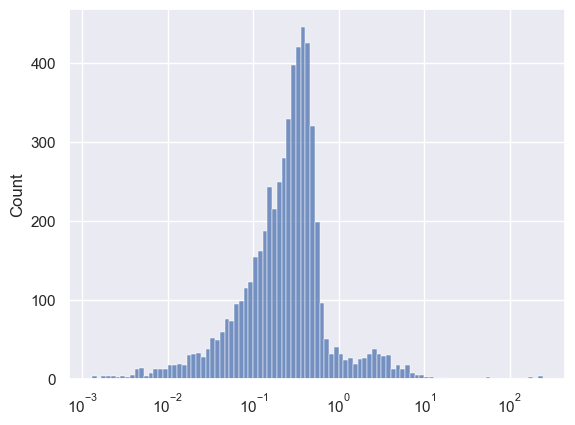

In [23]:
# what is the quality of the initial guess?

r = np.abs(residual(x0))
pd.Series(r).describe()
_ = sns.histplot(x=r[r>1e-3], log_scale=True)

In [24]:
cache_fit = True

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = f"./results/least-squares-fit-{digest(data, x0)}.npy"

if cache_fit and os.path.isfile(filename):
    opt = load(filename)
    print("Loaded from cache")
else:
    opt = scipy.optimize.least_squares(residual, x0, loss="soft_l1", xtol=None, verbose=2) 
    
    # save results and remove some stuff we don't need to save.
    del opt.jac
    del opt.active_mask
    del opt.fun
    
    save(filename, opt)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5353e+03                                    2.65e+07    
       1              8         2.3390e+03      1.96e+02       8.23e-02       1.48e+07    
       2             12         2.2710e+03      6.79e+01       1.29e-03       6.13e+06    
       3             14         2.2434e+03      2.77e+01       3.21e-04       6.76e+05    
       4             15         2.2341e+03      9.26e+00       6.43e-04       1.03e+05    
       5             16         2.2212e+03      1.29e+01       1.29e-03       2.40e+04    
       6             17         2.2034e+03      1.78e+01       2.57e-03       1.54e+04    
       7             18         2.1791e+03      2.43e+01       5.14e-03       1.15e+05    
       8             19         2.1385e+03      4.06e+01       1.03e-02       2.38e+05    
       9             20         2.1133e+03      2.52e+01       2.06e-02       2.40e+06    

In [25]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.562e-01  2.545e-01 ...  2.195e-01  9.953e-01]
       cost: 970.1076591930191
       grad: [-1.729e-05  1.028e-04 ...  6.970e-05 -7.303e-04]
 optimality: 1.1403826778405346
       nfev: 50
       njev: 35

count    5.735000e+03
mean     4.242805e-01
std      7.921451e-01
min      3.212381e-08
25%      1.321523e-01
50%      2.717381e-01
75%      4.231332e-01
max      1.365836e+01
dtype: float64

<Axes: ylabel='Count'>

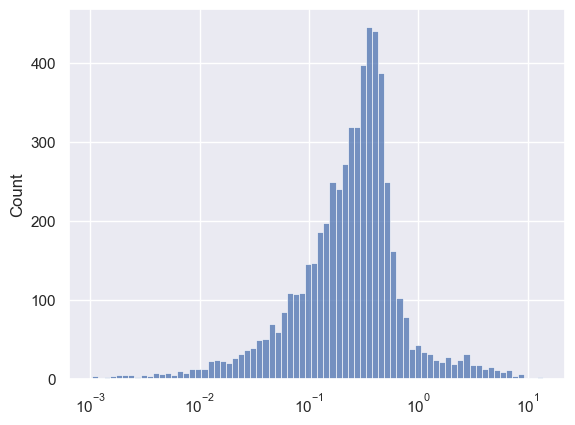

In [26]:
r_opt = np.abs(residual(opt.x))
pd.Series(r_opt).describe()
sns.histplot(x=r_opt[r_opt>1e-3], log_scale=True)

In [27]:
sol = unpack(opt.x, unpack_info)

table(sol)

Pokemons ing fractions,[0.25616874 0.25446908 0.26566096 ... 0.18017661 0.20047758 0.21664169]
Pokemons skill products,[16.73355441 16.70382755 18.44083501 ... 44.68610086 12.80169585 15.26674729]
Charge Strength S,[0.74808435 0.3220747 ]
Charge Strength M,[0.7447046 0.32287934]
Ingredient Magnet S,[0.74537576 0.32274097]
Cooking Power-Up S,[0.7447895 0.32268472]
Extra Helpful S,[0.74588453 0.32233976]
Charge Energy S,[0.74678654 0.32309799]
Energizing Cheer S,[0.73587373 0.33008493]
Energy for Everyone S,[0.74551194 0.32282787]
Dream Shard Magnet S,[0.74707451 0.32202959]


In [28]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({"Pokemon":game.pokedex.data["Pokemon"], "ing%": sol["Pokemons ing fractions"]*100.0, "skill% * skillValue": sol["Pokemons skill products"] })
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.616874,16.733554
Ivysaur,25.446908,16.703828
Venusaur,26.566096,18.440835
Charmander,20.035770,9.683459
Charmeleon,22.653572,14.058710
Charizard,22.387298,14.032205
Squirtle,26.997115,17.626709
Wartortle,27.047036,17.578513
Blastoise,27.433419,18.437877


In [29]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2,7)))
growth_display["Level"] = levels

for record in game.mainskills.data.to_dict(orient='records') :   
    
    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0]*np.exp(params[1]*levels)
    
df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.424627,1.420475,1.421361,1.420084,1.421191,1.425069,1.424005,1.421868,1.422575,1.421786
3,1.965968,1.961816,1.962769,1.960894,1.961746,1.968591,1.980913,1.963639,1.963048,1.964009
4,2.713011,2.709461,2.710402,2.707661,2.707903,2.719413,2.755621,2.711840,2.708860,2.713017
5,3.743923,3.742033,3.742815,3.738820,3.737864,3.756599,3.833307,3.745126,3.738026,3.747673
6,5.166568,5.168117,5.168482,5.162674,5.159574,5.189369,5.332461,5.172122,5.158197,5.176913


In [30]:
# What are the worst points?

df = data[["Pokemon","ID","Level","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
2539,Victreebel,VictreebelNeutral313Energy Recovery BonusInven...,31.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1713.0,1699.341637,13.658363,186.550879
1118,Gengar,GengarMild303Inventory Up MSleep EXP Bonus,30.0,3.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1904.0,1891.143160,12.856840,165.298346
1967,Raichu,RaichuLonely302Inventory Up MHelping bonus,30.0,2.0,Speed of Help,Energy Recovery,Inventory Up M,Helping bonus,1754.0,1742.923100,11.076900,122.697724
2012,Raticate,RaticateBrave301Inventory Up MSleep EXP Bonus,30.0,1.0,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1250.0,1240.595354,9.404646,88.447361
2363,Togekiss,TogekissGentle103Skill Trigger M,10.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.791042,9.208958,84.804916
387,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1430.804521,9.195479,84.556840
359,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1504.934826,9.065174,82.177388
2478,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1752.392235,8.607765,74.093621
571,Charmeleon,CharmeleonQuiet252Inventory Up MSleep EXP Bonus,25.0,2.0,Ingredient Finding,Exp Gains,Inventory Up M,Sleep EXP Bonus,1063.0,1054.393086,8.606914,74.078972
2772,Weepinbell,WeepinbellNeutral302Energy Recovery BonusInven...,30.0,2.0,-,-,Energy Recovery Bonus,Inventory Up M,1192.0,1183.733125,8.266875,68.341218
